In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
from tifffile import imread
import os
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
import seaborn as sns
import pickle

In [2]:
# marker names for immune, tumor, and their overlap
immune_markers = ['DNA_1','CD3', 'PDL1', 'GRZB','Ki67', 'PanCK', 'CD45','CD68', 'CD3d', 'CD8a',
             'CD163', 'aSMA', 'CD14','CD4', 'FOXP3', 'PDL1_2','CD11b', 'pRB', 'PD1',
             'LaminABC', 'PDL1_3', 'LAG3','CD20', 'HLA_A', 'MHC_II_DPB1']
tumor_markers = ['DNA_1','CD3', 'pERK', 'Rad51','CCND1', 'Vimentin', 'aSMA','Ecad', 'ER', 'PR',
            'EGFR', 'pRB', 'HER2','Ki67', 'CD45', 'p21','CK14','CK19', 'CK17',
            'LaminABC', 'AR', 'H2Ax','PCNA','PanCK', 'CD31']
shared_markers = ['DNA_1','CD3','aSMA','pRB','PanCK','CD45','Ki67','LaminABC']

In [3]:
def ids_to_table(ids, table):
    match_table = table[table['CellID'].isin(ids)] # get relevant rows
    df1 = match_table.set_index('CellID')
    match_table = df1.reindex(ids) # set new table in correct order
    return match_table

def get_correlations(markers, immune_table, tumor_table):
    correlations = []
    for i,s in enumerate(markers):
        correlations.append(spearmanr(immune_table[s],tumor_table[s])[0])
    return correlations

In [34]:
cores = ['A10','A5','A6','A8','B10','B1','B3','B4',
         'B6','B7','B9','C10','C1','C4','D11','D2','D8',
         'E10','E3','E5','E6','E7','E8','E9','F11','F1','F2','F7',
         'G11','G1','G3','G6','G7','G9','H10','H1',
         'H2','H3','H4','H6','H7','H8','H9']
cpath = '/home/groups/ChangLab/heussner/tma-integration/data/nuc_cell_tables'
#tracking_results = []
correlation_results = []
frac = []
for core in cores:
    corr_tracking = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/results/Cell_tracking_correlation/{core}.csv')
    tumor_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_tumor_both.csv'))
    immune_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_immune_both.csv'))
    corr_tracking = corr_tracking[corr_tracking['tumor_id']>0]
    imtbl = ids_to_table(corr_tracking['immune_id'],immune_all)
    tmtbl = ids_to_table(corr_tracking['tumor_id'],tumor_all)
    correlation_results.append(get_correlations(shared_markers, imtbl,tmtbl))
    frac.append(len(corr_tracking)/len(immune_all))
cr = np.array(correlation_results)

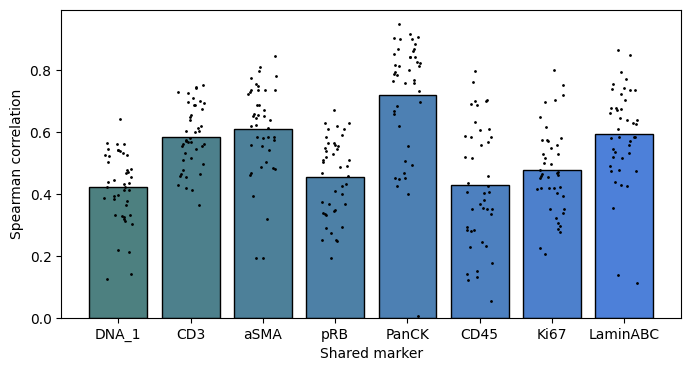

In [42]:
plt.figure(figsize=(8,4))
for i, m in enumerate(shared_markers):
    plt.bar(i, np.mean(cr,axis=0)[i], color=(0.3,.5,.5+.05*i),zorder=2,edgecolor='black')
    plt.scatter([i+np.random.randint(-20,20)/100 for k in range(len(cores))],cr[:,i],color='black',s=1,zorder=3)
plt.xticks([i for i in range(len(shared_markers))], shared_markers)
plt.xlabel('Shared marker')
plt.ylabel('Spearman correlation')
plt.show()

In [4]:
# load results:
cores = ['A10','A5','A6','A8','B10','B1','B3','B4',
         'B6','B7','B9','C10','C1','C4','D11','D2','D8',
         'E10','E3','E5','E6','E7','E8','E9','F11','F1','F2','F7',
         'G11','G1','G3','G6','G7','G9','H10','H1',
         'H2','H3','H4','H6','H7','H8','H9']

cpath = '/home/groups/ChangLab/heussner/tma-integration/data/nuc_cell_tables'
tracking_results = []
correlation_results = []
radius_results = []
for core in cores:
    corr_tracking = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/results/Cell_tracking_correlation/{core}.csv')
    corr_tracking = corr_tracking[corr_tracking['tumor_id']>0]
    
    overlap_tracking = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/results/Cell_tracking/{core}.csv')
    overlap_tracking = overlap_tracking[overlap_tracking['tumor_id']>0]
    
    radius_linear = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/results/Linear_assignment_radius/{core}.csv')
    radius_linear = radius_linear[radius_linear['tumor_id']>0]
    
    tumor_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_tumor_both.csv'))
    immune_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_immune_both.csv'))

    # add in missing pairs
    immune_new = []
    tumor_new = []
    for i, im in enumerate(corr_tracking['immune_id']):
        if im in list(overlap_tracking['immune_id']):
            immune_new.append(im)
            tumor_new.append(corr_tracking['tumor_id'].iloc[i])
    
    for i, im in enumerate(overlap_tracking['immune_id']):
        if im not in immune_new:
            immune_new.append(im)
            tumor_new.append(overlap_tracking['tumor_id'].iloc[i])

    imtbl = ids_to_table(overlap_tracking['immune_id'],immune_all)
    tmtbl = ids_to_table(overlap_tracking['tumor_id'],tumor_all)
    tracking_results.append(get_correlations(shared_markers, imtbl,tmtbl))

    imtbl = ids_to_table(immune_new,immune_all)
    tmtbl = ids_to_table(tumor_new,tumor_all)
    correlation_results.append(get_correlations(shared_markers, imtbl,tmtbl))

    imtbl = ids_to_table(radius_linear['immune_id'],immune_all)
    tmtbl = ids_to_table(radius_linear['tumor_id'],tumor_all)
    radius_results.append(get_correlations(shared_markers, imtbl,tmtbl))

In [5]:
cr = np.array(correlation_results)
tr = np.array(tracking_results)
r = np.array(radius_results)

cr_mean = np.mean(cr, axis=0)
tr_mean = np.mean(tr, axis=0)
r_mean = np.mean(r, axis=0)

cr_std = np.std(cr, axis=0)
tr_std = np.std(tr, axis=0)
r_std = np.std(r, axis=0)

In [24]:
cr.shape

(43, 8)

In [7]:
methods_mu = [tr_mean, cr_mean,r_mean]
methods_std = [tr_std, cr_std, r_std]
colors = ['red','green','blue']
labels = ['Tracking - overlap','Tracking - correlation','Linear assignment - radius']

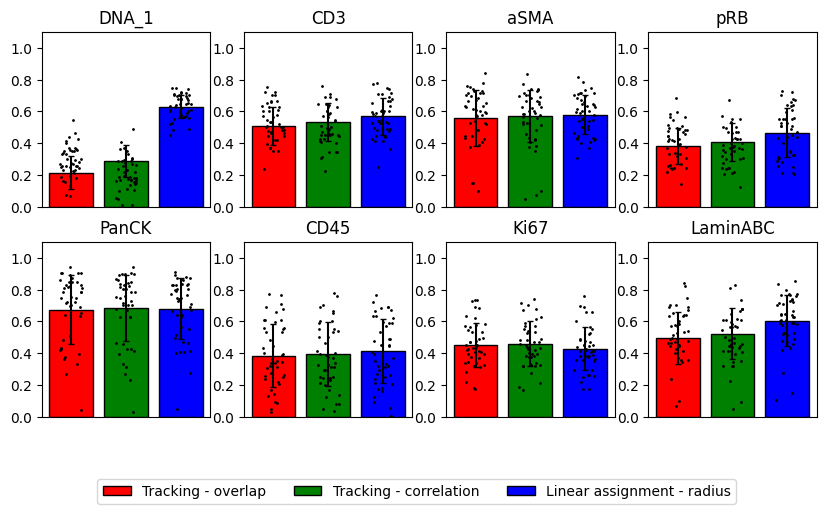

In [30]:
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax = ax.flatten()
for i,s in enumerate(shared_markers):
    for j,(mu,std) in enumerate(zip(methods_mu, methods_std)):
        if i == len(shared_markers)-1:
            label = labels[j]
        else:
            label = None
        bar = ax[i].bar([j+1],[mu[i]], 
                        yerr=[std[i]],color=colors[j],capsize=2,edgecolor='black',label=label)
        for b in bar:
            height = mu[i]+std[i]
            #ax[i].text(b.get_x() + b.get_width() / 2.0, height+.1, f'{mu[i]:.3f}', ha='center', va='bottom',fontsize=7)
    ax[i].scatter([1+np.random.randint(-20,20)/100 for k in range(len(cores))],cr[:,i],color='black',s=1)
    ax[i].scatter([2+np.random.randint(-20,20)/100 for k in range(len(cores))],tr[:,i],color='black',s=1)
    ax[i].scatter([3+np.random.randint(-20,20)/100 for k in range(len(cores))],r[:,i],color='black',s=1)
    ax[i].set_xticks([])
    ax[i].set_title(f'{s}')
    ax[i].set_ylim([0,1.1])
    ax[i].set_yticks([i*.2 for i in range(6)])

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          ncol=3, fancybox=True)
plt.show()

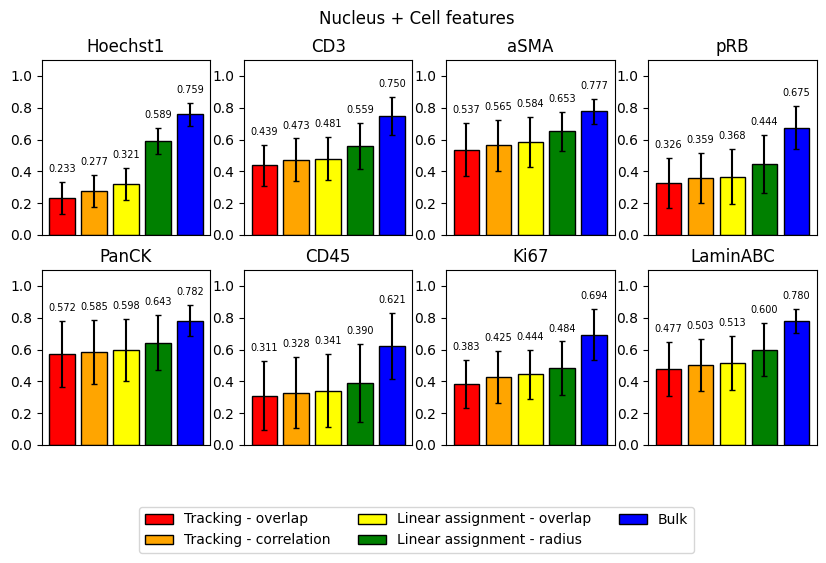

In [9]:
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax = ax.flatten()
for i,s in enumerate(shared_markers):
    for j,(mu,std) in enumerate(zip(methods_mu, methods_std)):
        if i == len(shared_markers)-1:
            label = labels[j]
        else:
            label = None
        bar = ax[i].bar([j+1],[mu[i]], 
                        yerr=[std[i]],color=colors[j],capsize=2,edgecolor='black',label=label)
        for b in bar:
            height = mu[i]+std[i]
            ax[i].text(b.get_x() + b.get_width() / 2.0, height+.05, f'{mu[i]:.3f}', ha='center', va='bottom',fontsize=7)
    ax[i].set_xticks([])
    #ax[i].set_ylabel(f'{s} Correlation')
    ax[i].set_title(f'{s}')
    ax[i].set_ylim([0,1.1])
    ax[i].set_yticks([i*.2 for i in range(6)])

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          ncol=3, fancybox=True)
#fig.legend(loc='outside lower center',bbox_to_anchor=(1.15,0))
#fig.tight_layout()
fig.suptitle('Nucleus + Cell features')
plt.show()

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(10,5))
ax = ax.flatten()
for i,s in enumerate(shared_markers):
    for j,(mu,std) in enumerate(zip(methods_mu, methods_std)):
        if i == len(shared_markers)-1:
            label = labels[j]
        else:
            label = None
        bar = ax[i].bar([j+1],[mu[i]], 
                        yerr=[std[i]],color=colors[j],capsize=2,edgecolor='black',label=label)
        for b in bar:
            height = mu[i]+std[i]
            ax[i].text(b.get_x() + b.get_width() / 2.0, height+.05, f'{mu[i]:.3f}', ha='center', va='bottom',fontsize=7)
    ax[i].set_xticks([])
    #ax[i].set_ylabel(f'{s} Correlation')
    ax[i].set_title(f'{s}')
    ax[i].set_ylim([0,1.1])
    ax[i].set_yticks([i*.2 for i in range(6)])

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          ncol=3, fancybox=True)
#fig.legend(loc='outside lower center',bbox_to_anchor=(1.15,0))
#fig.tight_layout()
fig.suptitle('Cell features')
plt.show()

In [1]:
# fig, ax = plt.subplots(2,4,figsize=(10,5))
ax = ax.flatten()
for i,s in enumerate(shared_markers):
    for j,(mu,std) in enumerate(zip(methods_mu, methods_std)):
        if i == len(shared_markers)-1:
            label = labels[j]
        else:
            label = None
        bar = ax[i].bar([j+1],[mu[i]], 
                        yerr=[std[i]],color=colors[j],capsize=2,edgecolor='black',label=label)
        for b in bar:
            height = mu[i]+std[i]
            ax[i].text(b.get_x() + b.get_width() / 2.0, height+.05, f'{mu[i]:.3f}', ha='center', va='bottom',fontsize=7)
    ax[i].set_xticks([1,2,3,4,5],['Tracking(o)','Tracking(c)', 'LA(o)', 'LA(r)','Bulk'],fontsize=4)
    ax[i].set_ylabel('Correlation')
    ax[i].set_title(f'{s}')
    ax[i].set_ylim([0,1.1])
    ax[i].set_yticks([i*.2 for i in range(6)])
    #for b in bar:
    #    height = b.get_height()
    #    ax[i].text(b.get_x() + b.get_width() / 2.0, height+.22, f'{height:.3f}', ha='center', va='bottom',fontsize=7)
#fig.legend(loc='lower center',bbox_to_anchor=(1.1,0))
fig.tight_layout()
plt.show()

NameError: name 'ax' is not defined

In [5]:
core = 'B3'
cpath = '/home/groups/ChangLab/heussner/tma-integration/data/cell_tables'
tumor_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_tumor_cell.csv'))
immune_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_immune_cell.csv'))

In [38]:
cols = ['x','y']
sdist = pairwise_distances(immune_all[cols].to_numpy(), immune_all[cols].to_numpy())

In [12]:
np.fill_diagonal(sdist,10000)
ax0 = np.min(sdist, axis=0)
#ax1 = np.min(sdist, axis=1)

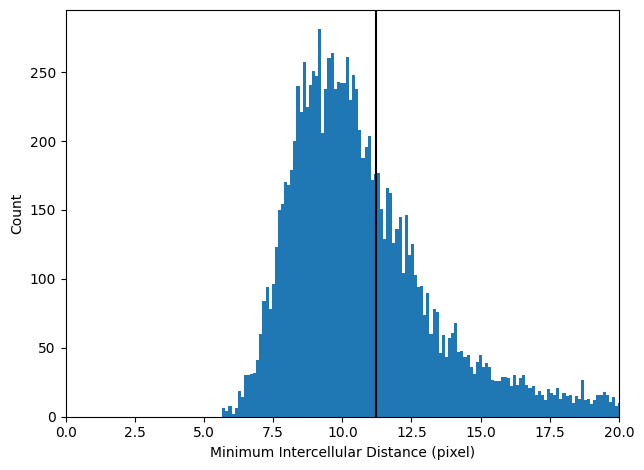

In [13]:
#tot = np.concatenate([ax0])*0.325
plt.hist(ax0, bins=1000)
plt.xlabel(u'Minimum Intercellular Distance (pixel)')#(\u03bcm)')
plt.ylabel('Count')
plt.axvline(np.mean(ax0),color='black')
plt.tight_layout()
plt.xlim([0,20])
plt.show()

In [14]:
np.std(ax0)*3

11.717514876970018

In [6]:
cr.shape

(43, 8)

In [7]:
tr.shape

(43, 8)

In [6]:
norm = (cr - tr)/tr * 100

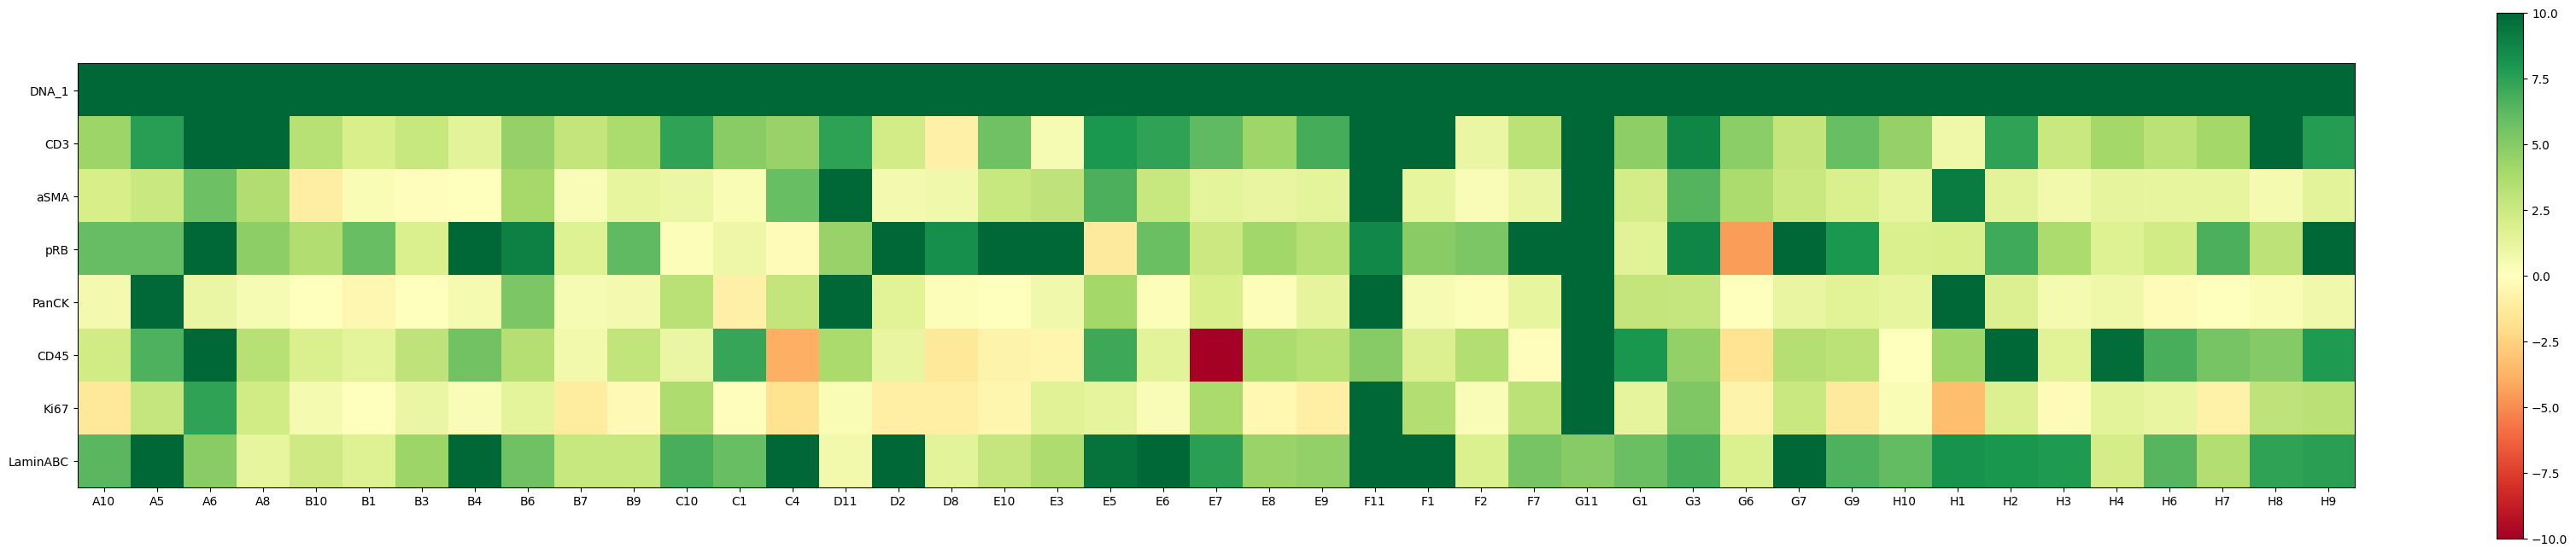

In [9]:
plt.figure(figsize=(norm.shape[0],norm.shape[1]))
cbar = plt.imshow(norm.T,vmin=-10,vmax=10,cmap='RdYlGn')
plt.yticks([0,1,2,3,4,5,6,7],shared_markers)
plt.xticks([i for i in range(len(cores))],cores)
plt.colorbar(cbar,cmap='Reds')
plt.show()

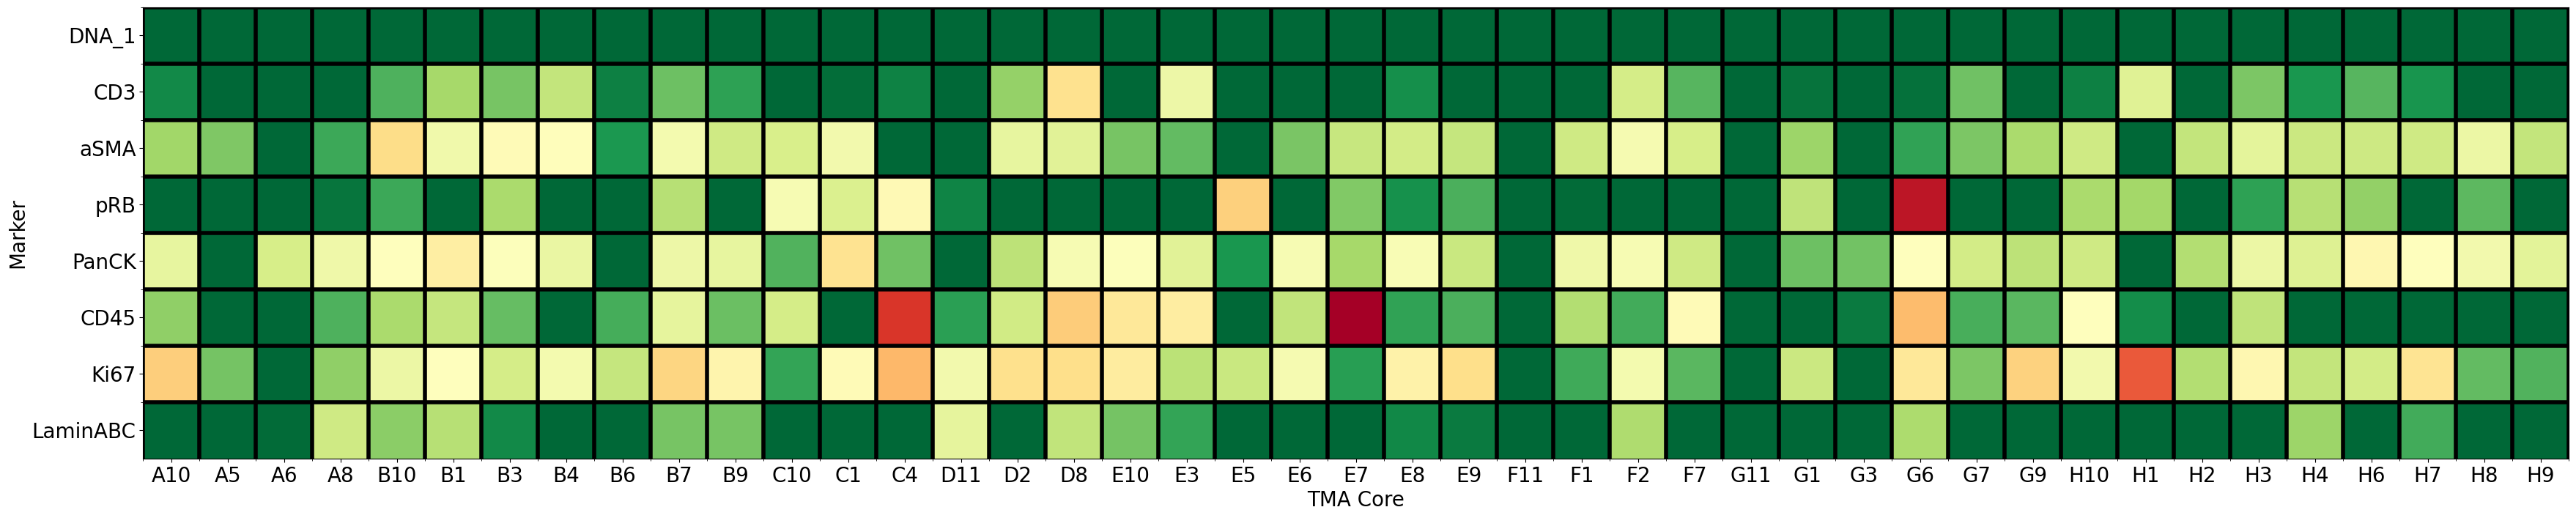

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(norm.shape[0],norm.shape[1]))
ax = plt.gca()
cbar = ax.imshow(norm.T,vmin=-5,vmax=5,cmap='RdYlGn')
ax.set_yticks([0,1,2,3,4,5,6,7],shared_markers,fontsize=20)
ax.set_xticks([i for i in range(len(cores))],cores,fontsize=20)

# Minor ticks
ax.set_xticks(np.arange(-.5, 43, 1), minor=True)
ax.set_yticks(np.arange(-.5, 7, 1), minor=True)

ax.set_xlabel('TMA Core',fontsize=20)
ax.set_ylabel('Marker',fontsize=20)
# Gridlines based on minor ticks
ax.grid(which='minor', color='black', linestyle='-', linewidth=4)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="1%", pad=0.05)

#cbar = plt.colorbar(cbar,ax=ax,fraction=0.05, pad=0.02)
#cbar.ax.tick_params(labelsize=20)
#cbar.set_label(r'$\Delta$ Spearman Correlation (%) ', rotation=270,fontsize=20)
#plt.tight_layout()
plt.show()
#plt.tight_layout()
#plt.show()

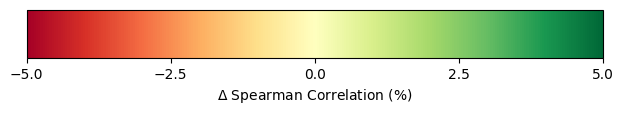

In [31]:
import matplotlib as mpl
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal',
                               norm=mpl.colors.Normalize(-5, 5),
                               ticks = [-5,-2.5,0,2.5,5],
                               label = r'$\Delta$ Spearman Correlation (%)',
                               cmap='RdYlGn')

# with open('cyclic.pkl','rb') as handle:
    results = pickle.load(handle)

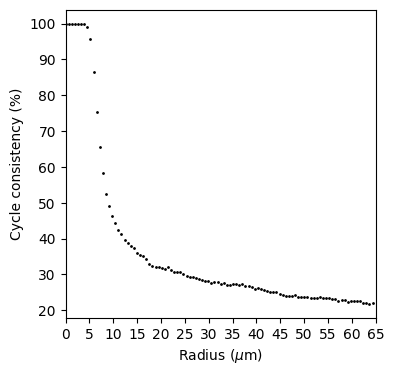

In [91]:
r = [i*0.65 for i in range(300)][0:100]
y = results['B3'][0][0:100]
plt.figure(figsize=(4,4))
plt.scatter(r,[i*100 for i in y], s=1, color='black')
plt.xlabel(r'Radius ($\mu$m)')
plt.xticks([i*5 for i in range(14)])
plt.xlim([0,65])
plt.ylabel('Cycle consistency (%)')
plt.show()

In [28]:
tumor_cell_table = pd.read_csv('/home/groups/ChangLab/heussner/tma-integration/data/cell_tables/B3_tCyCIF_tumor_cell.csv')
tumor_nuc_table = pd.read_csv('/home/groups/ChangLab/heussner/tma-integration/data/nuc_tables/B3_tCyCIF_tumor_nuc.csv')
immune_cell_table = pd.read_csv('/home/groups/ChangLab/heussner/tma-integration/data/cell_tables/B3_tCyCIF_immune_cell.csv')
immune_nuc_table = pd.read_csv('/home/groups/ChangLab/heussner/tma-integration/data/nuc_tables/B3_tCyCIF_immune_nuc.csv')

In [30]:
tumor_cell_table.columns

Index(['CellID', 'DNA_1', 'AF488', 'AF555', 'AF647', 'DNA_2', 'Control_488',
       'Control_555', 'Control_647', 'DNA_3', 'CD3', 'pERK', 'Rad51', 'DNA_4',
       'CCND1', 'Vimentin', 'aSMA', 'DNA_5', 'Ecad', 'ER', 'PR', 'DNA_6',
       'EGFR', 'pRB', 'HER2', 'DNA_7', 'Ki67', 'CD45', 'p21', 'DNA_8', 'CK14',
       'CK19', 'CK17', 'DNA_9', 'LaminABC', 'AR', 'H2Ax', 'DNA_10', 'PCNA',
       'PanCK', 'CD31', 'Area', 'MajorAxisLength', 'MinorAxisLength',
       'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'x', 'y'],
      dtype='object')

In [31]:
immune_cell_table.columns

Index(['CellID', 'DNA_1', 'AF488', 'AF555', 'AF647', 'DNA_2', 'Control_488',
       'Control_555', 'Control_647', 'DNA_3', 'CD3', 'PDL1', 'GRZB', 'DNA_4',
       'Ki67', 'PanCK', 'CD45', 'DNA_5', 'CD68', 'CD3d', 'CD8a', 'DNA_6',
       'CD163', 'aSMA', 'CD14', 'DNA_7', 'CD4', 'FOXP3', 'PDL1_2', 'DNA_8',
       'CD11b', 'pRB', 'PD1', 'DNA_9', 'LaminABC', 'PDL1_3', 'LAG3', 'DNA_10',
       'CD20', 'HLA_A', 'MHC_II_DPB1', 'Area', 'MajorAxisLength',
       'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation',
       'x', 'y'],
      dtype='object')

In [32]:
tumor_nuc_table.columns

Index(['CellID', 'Hoechst1', 'AF488', 'AF555', 'AF647', 'Hoechst2',
       'A488 d-a-rat', 'A555 d-a-rabbit', 'A647 d-a-mouse', 'Hoechst3', 'CD3',
       'pERK', 'Rad51', 'Hoechst4', 'CCND1', 'Vimentin', 'aSMA', 'Hoechst5',
       'Ecad', 'ER', 'PR', 'Hoechst6', 'EGFR', 'pRB', 'HER2', 'Hoechst7',
       'Ki67', 'CD45', 'p21', 'Hoechst8', 'CK14', 'CK19', 'CK17', 'Hoechst9',
       'LaminABC', 'AR', 'H2Ax', 'Hoechst10', 'PCNA', 'PanCK', 'CD31',
       'eccentricity', 'major_axis_length', 'minor_axis_length',
       'equivalent_diameter', 'area', 'centroid-0', 'centroid-1', 'x', 'y'],
      dtype='object')

In [33]:
immune_nuc_table.columns

Index(['CellID', 'Hoechst1', 'AF488', 'AF555', 'AF647', 'Hoechst2',
       'A488 d-a-rat', 'A555 d-a-rabbit', 'A647 d-a-mouse', 'Hoechst3', 'CD3',
       'PD-L1_(SP142)', 'GranB', 'Hoechst4', 'Ki67', 'PanCK', 'CD45',
       'Hoechst5', 'CD68', 'CD3d', 'CD8a', 'Hoechst6', 'CD163', 'aSMA', 'CD14',
       'Hoechst7', 'CD4', 'FOXP3', 'PD-L1 (E1L3N)', 'Hoechst8', 'CD11b', 'pRB',
       'PD1', 'Hoechst9', 'LaminABC', 'PD-L1 (28-8)', 'LAG3', 'Hoechst10',
       'CD20', 'HLAA', 'HLA-DPB1', 'eccentricity', 'major_axis_length',
       'minor_axis_length', 'equivalent_diameter', 'area', 'centroid-0',
       'centroid-1', 'x', 'y'],
      dtype='object')

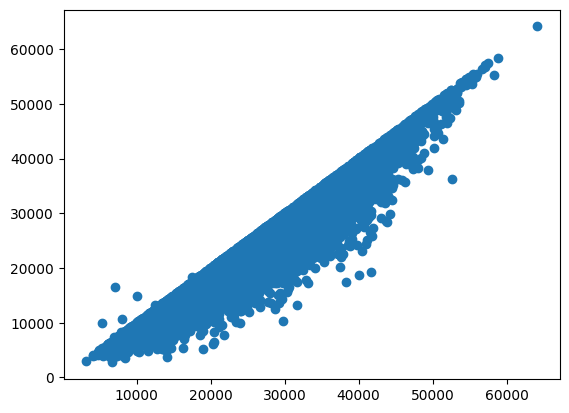

In [34]:
plt.scatter(immune_nuc_table['Hoechst1'],immune_cell_table['DNA_1'])
plt.show()

In [21]:
def ids_to_table(ids, table):
    match_table = table[table['CellID'].isin(ids)] # get relevant rows
    df1 = match_table.set_index('CellID')
    match_table = df1.reindex(ids) # set new table in correct order
    return match_table

def get_correlations(markers, immune_table, tumor_table):
    correlations = []
    for i,s in enumerate(markers):
        correlations.append(spearmanr(immune_table[s],tumor_table[s])[0])
    return correlations

In [23]:
cpath = '/home/groups/ChangLab/heussner/tma-integration/data/nuc_cell_tables'
tumor_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_tumor_both.csv'))
immune_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_immune_both.csv'))

In [14]:
core='B3'
overlap_tracking = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/tracking/tracking_no_overlap/{core}.csv')
overlap_tracking = overlap_tracking[overlap_tracking['tumor_id']>0]
imtbl = ids_to_table(overlap_tracking['immune_id'],immune_all)
tmtbl = ids_to_table(overlap_tracking['tumor_id'],tumor_all)

In [13]:
# pearson correlation
np.mean(get_correlations(shared_markers, imtbl,tmtbl))

0.5662101686677623

In [22]:
# spearman correlation
np.mean(get_correlations(shared_markers, imtbl,tmtbl))

0.6010666844719627

In [15]:
# pearson correlation
np.mean(get_correlations(shared_markers, imtbl,tmtbl))

0.5664865922365492

In [41]:
path = '/home/groups/ChangLab/heussner/tma-integration/data/cell_tables/'
cell = pd.read_csv(os.path.join(path,f'{core}_tCyCIF_tumor_cell.csv'))['CellID'].to_numpy()
path = '/home/groups/ChangLab/heussner/tma-integration/data/nuc_cell_tables/'
both = pd.read_csv(os.path.join(path,f'{core}_tCyCIF_tumor_both.csv'))['CellID'].to_numpy()

In [42]:
np.sum(cell-both)

0

In [44]:
path = '/home/groups/ChangLab/heussner/tma-integration/data/nuc_tables/'
tumor_all = pd.read_csv(os.path.join(path,f'{core}_tCyCIF_tumor_nuc.csv'))

In [45]:
tumor_all

,CellID,Hoechst1,AF488,AF555,AF647,Hoechst2,A488 d-a-rat,A555 d-a-rabbit,A647 d-a-mouse,Hoechst3,...,CD31,eccentricity,major_axis_length,minor_axis_length,equivalent_diameter,area,centroid-0,centroid-1,x,y
0,2,22270.374233,914.674847,198.404908,375.760736,167.374233,817.969325,124.852761,483.503067,116.680982,...,1214.134969,0.636168,16.438457,12.683106,14.406181,163.0,42.226994,2407.650307,33.226994,2331.650307
1,4,15830.266667,731.366667,169.266667,384.100000,4702.700000,898.866667,172.683333,498.516667,8994.283333,...,1215.383333,0.379878,9.204579,8.514573,8.740387,60.0,200.100000,1430.716667,183.100000,1354.716667
2,5,7079.833333,687.583333,154.000000,378.666667,2049.750000,824.333333,149.916667,500.583333,1692.750000,...,1204.416667,0.490719,4.167620,3.631322,3.908820,12.0,206.666667,1393.750000,189.666667,1317.750000
3,6,17536.438017,902.388430,204.396694,386.487603,6730.429752,1088.090909,230.429752,614.851240,15548.033058,...,1231.123967,0.791816,16.177155,9.880362,12.412171,121.0,207.702479,1428.462810,190.702479,1352.462810
4,7,10007.493827,701.419753,155.074074,376.358025,3686.049383,870.555556,155.382716,440.456790,3024.901235,...,1247.395062,0.287712,10.404933,9.964981,10.155413,81.0,209.234568,1126.506173,189.234568,1051.506173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8794,9004,5151.406061,1610.830303,327.981818,376.878788,10206.836364,1739.000000,388.866667,437.915152,7536.442424,...,1286.484848,0.965681,36.761111,9.548059,14.494293,165.0,1215.393939,549.303030,1371.909091,1045.363636
8795,9005,6406.266667,1572.066667,324.933333,383.033333,3617.766667,1070.166667,196.566667,359.066667,424.733333,...,1217.866667,0.426240,6.502745,5.882448,6.180387,30.0,1293.600000,1602.966667,1616.851852,194.629630
8796,9006,8095.454545,909.727273,197.545455,368.363636,5567.545455,1081.363636,197.454545,346.090909,12502.272727,...,2074.727273,0.708444,4.346130,3.067356,3.742410,11.0,1393.909091,1130.363636,1663.438819,1927.168776
8797,9007,3961.148148,936.888889,204.074074,375.629630,3205.666667,1141.444444,240.703704,407.222222,2739.666667,...,1240.629630,0.728422,7.120032,4.878137,5.863230,27.0,1645.851852,280.629630,NaN,NaN


In [26]:
cols = ['x','y']
tumor_spatial = tumor_all[cols].to_numpy()
sdist = pairwise_distances(tumor_spatial, tumor_spatial)

In [27]:
cores = ['A10','A5','A6','A8','B10','B1','B3','B4',
         'B6','B7','B9','C10','C1','C4','D11','D2','D8',
         'E10','E3','E5','E6','E7','E8','E9','F11','F1','F2','F7',
         'G11','G1','G3','G6','G7','G9','H10','H1',
         'H2','H3','H4','H6','H7','H8','H9']

for core in tqdm(cores):
    # read tCyCIF data
    
    tracking = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/tracking/tracking_overlap_spearman/{core}.csv')
    tracking = tracking[tracking['tumor_id']>0]
    #all cells tables
    path = '/home/groups/ChangLab/heussner/tma-integration/data/nuc_tables/'
    tumor_all = pd.read_csv(os.path.join(path,f'{core}_tCyCIF_tumor_nuc.csv'))
    immune_all = pd.read_csv(os.path.join(path,f'{core}_tCyCIF_immune_nuc.csv'))
    cols = ['x','y']
    sdist = pairwise_distances(immune_all[cols].to_numpy(), immune_all[cols].to_numpy())
    np.fill_diagonal(sdist,10000)
    ax0 = np.min(sdist, axis=0)
    radius = np.mean(ax0)+ 3*np.std(ax0)
    #normalize tracked cells based on full population
    immune_all_norm = immune_all[immune_markers].copy()
    immune_all_norm = zscore(immune_all_norm)
    immune_all_norm['CellID'] = immune_all['CellID'].copy()
    immune_tracked_norm = ids_to_table(tracking['immune_id'], immune_all_norm)
    
    # load matrices
    
    immune = immune_tracked_norm[shared_markers].copy()
    tumor = tumor_all[shared_markers].copy()
    
    tumor = zscore(tumor,axis=0)
    #pearson correlation distance

    cdist = 1 - spearmanr(a=immune,
                     b=tumor, 
                     axis=1)[0][0:len(immune),len(immune):len(immune)+len(tumor)]
    #euclidean distance between target cells
    cols = ['x','y']
    tumor_spatial = tumor_all[cols].to_numpy()
    sdist = pairwise_distances(tumor_spatial, tumor_spatial)
    
    matched_indexes = [tumor_all[tumor_all['CellID']==i].index for i in list(tracking['tumor_id'])]
    dist = cdist.copy()
    for i,match in enumerate(matched_indexes):
        # get target indices within radius r from sdist
        row = sdist[match,:].copy()
        indexes = list(np.where(row<=radius))
        # replace values in cdist
        mask = np.ones(dist[i,:].size, dtype=bool)
        mask[indexes] = False
        dist[i,:][mask] = np.inf
    
    rows, cols = linear_sum_assignment(dist)
    scores = np.array([cdist[i, j] for i, j in zip(rows, cols)])
    matching = [list(tracking['immune_id']), [tumor_all['CellID'].iloc[c] for c in cols], scores]
    table = pd.DataFrame(data={'immune_id':matching[0],'tumor_id':matching[1],'score':matching[2]})

  0%| | 0/43 [00:35<?, ?it/


ValueError: Input contains NaN.

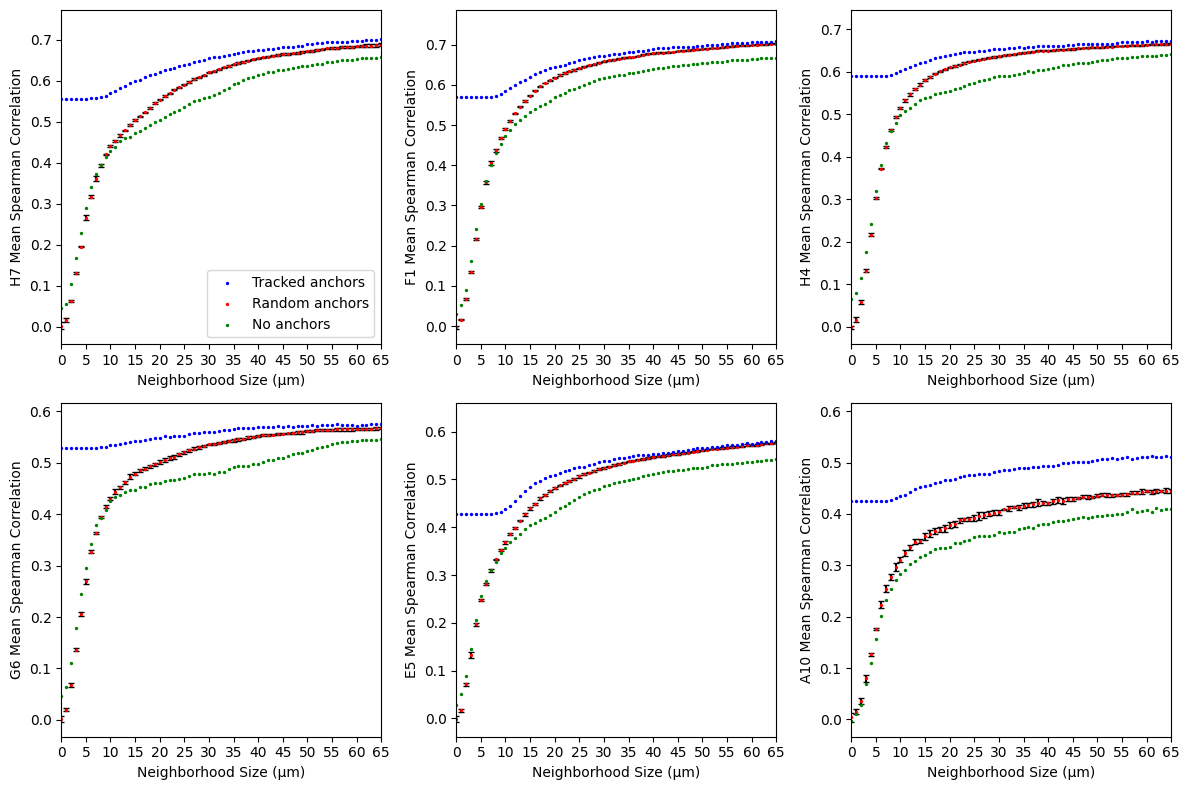

In [7]:
fig, ax = plt.subplots(2,3, figsize=(12,8))
ax = ax.flatten()
radii = [i for i in range(301)]
cores = ['H7','F1','H4','G6','E5','A10']
path = '/home/groups/ChangLab/heussner/tma-integration/results/Radius_exploration_supplementary'
for i,c in enumerate(cores):
    with open(os.path.join(path,f'sla_random_spearman_{c}.pkl'),'rb') as handle:
        sla_random = np.array(pickle.load(handle))
    
    with open(os.path.join(path,f'sla_track_spearman_{c}.pkl'),'rb') as handle:
        sla_track = pickle.load(handle)
    
    with open(os.path.join(path,f'sla_all_spearman_{c}.pkl'),'rb') as handle:
        sla_all = pickle.load(handle)

    #with open(os.path.join(path,f'{c}_no_constraints.pkl'),'rb') as handle:
    #    no_constraints = pickle.load(handle)
    sla_random_mean = np.mean(sla_random, axis=0)
    sla_random_std = np.std(sla_random, axis=0)

    ax[i].scatter(radii, sla_track, color='blue', label='Tracked anchors',s=2,zorder=2)
    ax[i].scatter(radii, sla_random_mean, color='red',label='Random anchors',s=2,zorder=1)
    ax[i].scatter(radii, sla_all, color='green',label='No anchors',s=2)
    #ax[i].axhline(no_constraints, color='grey',linestyle='--',label='Unconstrained')
    ax[i].errorbar(radii, sla_random_mean, yerr=sla_random_std,fmt="none",ecolor='black',capsize=2,zorder=0)
    ax[i].set_xlabel(u'Neighborhood Size (\u03bcm)')
    ax[i].set_ylabel(f'{c} Mean Spearman Correlation')
    ax[i].set_xticks([j*5 for j in range(14)])
    ax[i].set_xlim([0,65])
ax[0].legend()
plt.tight_layout()
plt.savefig('Radius_expansion_supplementary.png',dpi=600)
plt.show()